In [ ]:
#A/B testing for a website conversion rate. 
#Running an A/B test to test whether the experimental yields a better conversion rate for a website than the current theme

In [ ]:
#Step1:Evaluate the data

In [1]:
import pandas as pd
df=pd.read_csv("ab_data.csv")

In [2]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [ ]:
#The data shows users are divided into two groups. Control and treatment:  Control group will be shown the current design and treatent group will be shown the new design. A conversion rate of 0 means not converted and 1 means converted. Lets do some exploratory analysis to find out how does the conversion rate looks like with different groups.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
#the statistics above shows that the experiment was run for 294478 users. 

In [4]:
df.groupby('group').agg(['count'])

,user_id,timestamp,landing_page,converted
,count,count,count,count
group,,,,
control,147202,147202,147202,147202
treatment,147276,147276,147276,147276


In [ ]:
#The data shows approx 50-50 distribution between control and test group.

In [5]:
df.groupby('group').agg({'converted': ['sum']})

,converted
,sum
group,
control,17723
treatment,17514


In [6]:
import seaborn as sns

<AxesSubplot:xlabel='group'>

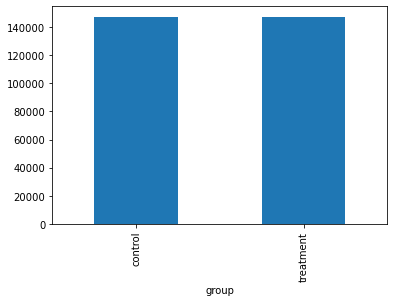

In [7]:
df.groupby(['group']).size().plot(kind = "bar")

In [ ]:
## the graph shows 50-50 distribution

In [ ]:
# Checking the converted distribution for treatment and control group.


<AxesSubplot:xlabel='group,converted'>

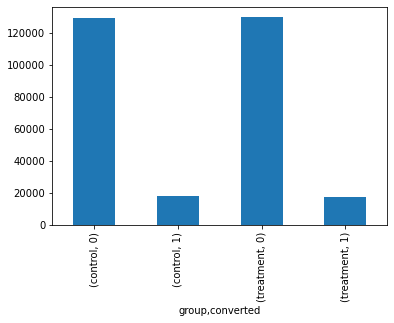

In [8]:
df.groupby(['group','converted'])['converted'].count().plot.bar()

In [ ]:
## from the distribution it looks like that both the groups have similar conversion rates.However lets do futher analysis to find out more.


In [9]:
#Checking the  number of users landing on new and old page
import pandas as pd
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [10]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [11]:
# we drop the second time the instance used the homepage
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [12]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


In [ ]:
#The dataset looks much cleaner now

In [ ]:
#Design  the a/b test experiment:
#We will choose a two tailed test as we dont know whether the new design is better or worse than the current one. Hypothesis will be formulated as below:
#Hₒ: p = pₒ

#Hₐ: p ≠ pₒ

#where p and pₒ stand for the conversion rate of the new and old design, respectively. We’ll also set a confidence level of 95%:

In [ ]:
#While doing an a/b test it is very important to chose the right sample size as we wont use the whole population base . Lets chose the right sample size

In [13]:
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [14]:
effect_size = sms.proportion_effectsize(0.13, 0.15,method='normal')
effect_size

-0.0576728617308947

In [15]:
#Calculating the sample size:
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


Sampling the data to get the needed number of data samples.Using pandas DataFrame.sample() method to do this, which will get random sampling results for us

In [16]:
control_sample=df[df['group']=='control'].sample(n=required_n,random_state=22)
treatment_sample=df[df['group']=='treatment'].sample(n=required_n,random_state=22)
ab_test=pd.concat([control_sample,treatment_sample],axis=0)
ab_test.reset_index(drop=True,inplace=True)
ab_test


,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [17]:
ab_test['group'].value_counts()

treatment    4720
control      4720
Name: group, dtype: int64

In [ ]:
#lets see how this sample looks like

In [18]:
conversion_rates=ab_test.groupby('group')['converted']

In [23]:
conversion_rates

In [ ]:
#Calculating the basic statistics to see how does the sample look like

In [19]:
import numpy as np
std_p=lambda x:np.std(x,ddof=0) #Std. deviation of proportion
se_p=lambda x:stats.sem(x,ddof=0) #Std. error of proportion

conversion_rates=conversion_rates.agg([np.mean,std_p,se_p])
conversion_rates.columns=['conversion_rate','std_deviation','std_error']
conversion_rates



,conversion_rate,std_deviation,std_error
group,,,
control,0.123305,0.328787,0.004786
treatment,0.125636,0.331438,0.004824


In [ ]:
#The intial statistical analysis shows there not to be much difference in the performance of control and treatment group

In [26]:
#Developing the hypothesis testing

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [24]:
from statsmodels.stats.proportion import proportions_ztest,proportion_confint
control_results=ab_test[ab_test['group']=='control']['converted']
treatment_results=ab_test[ab_test['group']=='treatment']['converted']
n_con=control_results.count()
n_treat=treatment_results.count()
control_results
treatment_results
n_con
n_treat

4720

In [25]:
successes=[control_results.sum(),treatment_results.sum()]
nobs=[n_con,n_treat]
z_stat,pval=proportions_ztest(successes,nobs=nobs)
(lower_con,lower_treat),(upper_con,upper_treat)=proportion_confint(successes,nobs=nobs,alpha=0.05)
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


In [ ]:
#Conclusion:
Since the p-value is above the threshhold of 0.05, we cannot reject the null hypothesis. Hence, the new design did not perform significantly better/worse than the old deaign.
additionally, looking at the confidence interval,it includes the baseline of 13% conversion rate.It does not include the target value of 15% (2%  better performance we were looking for)
